## Trader Quality Score (TQS) Analysis 

#### Objective: 
Compute individual trader-level quantitative metrics and generate a composite Trader Quality Score (TQS) to rank and classify trader performance.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('../data/processed/preprocessed_trades.csv')

print("Dataset Info:")
print(df.info())
print("\nSample Data:")
display(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712194 entries, 0 to 712193
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   identifier              712194 non-null  int64  
 1   action                  712194 non-null  int64  
 2   reason                  712194 non-null  float64
 3   open_price              712194 non-null  float64
 4   close_price             712194 non-null  float64
 5   commission              712194 non-null  float64
 6   lot_size                712194 non-null  float64
 7   opened_at               712194 non-null  object 
 8   closed_at               712194 non-null  object 
 9   pips                    712194 non-null  float64
 10  price_sl                712194 non-null  float64
 11  price_tp                712194 non-null  float64
 12  profit                  712194 non-null  float64
 13  swap                    712194 non-null  float64
 14  symbol

,identifier,action,reason,open_price,close_price,commission,lot_size,opened_at,closed_at,pips,...,platform,phase,user_id,challenge_id,asset_class,trade_duration_seconds,trade_duration_minutes,trade_duration_hours,sl_set,tp_set
0,44041186,0,16.0,3332.900,3332.880,-0.07,0.01,2025-05-05 23:41:50.000,2025-05-06 00:00:10.000,0.2,...,0,3,535946,4793871,Metals,1100.0,18.333333,0.305556,0,0
1,44045174,1,16.0,19921.400,19924.870,0.00,0.84,2025-05-05 23:58:19.000,2025-05-06 00:01:17.000,34.7,...,0,0,1259367,3271436,Indices,178.0,2.966667,0.049444,1,1
2,44038318,1,16.0,143.654,143.756,-1.50,0.75,2025-05-05 23:27:58.000,2025-05-06 00:01:52.000,10.2,...,0,0,533885,1158518,Forex,2034.0,33.900000,0.565000,0,1
3,44042511,1,16.0,143.655,143.757,-1.50,0.75,2025-05-05 23:48:20.000,2025-05-06 00:01:58.000,10.2,...,0,0,533885,1158518,Forex,818.0,13.633333,0.227222,0,1
4,44046179,0,16.0,3333.370,3333.270,-2.00,1.00,2025-05-06 00:00:49.000,2025-05-06 00:02:00.000,1.0,...,0,1,969510,2064915,Metals,71.0,1.183333,0.019722,1,1


#### Note:
This dataset contains individual trade records with info like profit, lot size, commission, trade duration, and trader identifier (user_id).

In [3]:
# Filter out traders with fewer than 10 trades (statistical noise)
df_filtered = df.groupby('user_id').filter(lambda x: len(x) >= 10)

Traders with fewer than 10 trades are excluded to avoid overfitting to outliers and to focus on meaningful behavior.

### 2. Aggregate Metrics Per Trader

#### Description
Group trade data by user_id and compute basic aggregated features:
- Number of trades
- Total profit
- Win rate (fraction of profitable trades)
- Average and total lot size
- Total commission
- Std dev of profit rate (risk proxy)
- Average trade duration (hours)


In [4]:
grouped = df_filtered.groupby('user_id').agg(
    num_trades=('identifier', 'count'),
    total_profit=('profit', 'sum'),
    win_rate=('profit', lambda x: (x > 0).sum() / len(x)),
    avg_profit_rate=('profit_rate', 'mean'),
    std_profit_rate=('profit_rate', 'std'),
    total_commission=('commission', 'sum'),
    total_lot_size=('lot_size', 'sum'),
    avg_lot_size=('lot_size', 'mean'),
    avg_duration_hr=('trade_duration_hours', 'mean')
).reset_index()

print("Aggregated Metrics Per Trader:")
display(grouped.head())

Aggregated Metrics Per Trader:


,user_id,num_trades,total_profit,win_rate,avg_profit_rate,std_profit_rate,total_commission,total_lot_size,avg_lot_size,avg_duration_hr
0,127,10,167.21,0.700000,1.000000,0.000000,0.00,1.00,0.100000,0.118028
1,208,10,-294.04,0.400000,1.000000,0.000000,-15.30,7.75,0.775000,1.050139
2,238,11,-283.70,0.181818,0.909726,0.299407,-11.40,5.70,0.518182,0.381490
3,299,10,156.50,0.700000,0.900697,0.314025,-2.64,2.57,0.257000,18.775750
4,313,10,-650.64,0.200000,1.000000,0.000000,-18.92,9.46,0.946000,1.622861


#### Note:
This section quantifies core performance indicators such as profitability, trade count, risk proxy, and trading behavior.


### 3. Define Functions for Advanced Metrics

These metrics capture behavioral patterns and performance quality beyond raw stats:
- Profit Factor: ratio of gross profit to gross loss
- Max Win Streak: longest consecutive profitable trades
- Max Loss Streak: longest consecutive losing trades
- Risk-Reward Ratio: average win size divided by average loss size

In [5]:
def calc_profit_factor(trades):
    gross_profit = trades.loc[trades['profit'] > 0, 'profit'].sum()
    gross_loss = trades.loc[trades['profit'] < 0, 'profit'].abs().sum()
    return gross_profit / gross_loss if gross_loss != 0 else np.nan

In [6]:
def calc_streaks(profits):
    max_win_streak = 0 
    max_loss_streak = 0
    current_win_streak = 0
    current_loss_streak = 0

    for p in profits:
        if p > 0:
            current_win_streak += 1
            current_loss_streak = 0
        elif p < 0:
            current_loss_streak += 1
            current_win_streak = 0
        else:
            current_win_streak = 0
            current_loss_streak = 0
            
        max_win_streak = max(max_win_streak, current_win_streak)
        max_loss_streak = max(max_loss_streak, current_loss_streak)
    return max_win_streak, max_loss_streak

In [7]:
def calc_risk_reward(trades):
    avg_win = trades.loc[trades['profit'] > 0, 'profit'].mean()
    avg_loss = trades.loc[trades['profit'] < 0, 'profit'].abs().mean()
    return avg_win / avg_loss if avg_loss and not pd.isna(avg_win) else 0

### 4. Compute Advanced Metrics per Trader

Apply the above functions on each trader's trades to extract behavioral metrics


In [8]:
def compute_advanced_metrics(df):
    results = []
    for user_id, group in df.groupby('user_id'):
        profit_factor = calc_profit_factor(group)
        win_streak, loss_streak = calc_streaks(group['profit'].values)
        rr_ratio = calc_risk_reward(group)
        results.append({
            'user_id': user_id,
            'profit_factor': profit_factor,
            'max_win_streak': win_streak,
            'max_loss_streak': loss_streak,
            'risk_reward_ratio': rr_ratio
        })
    return pd.DataFrame(results)

advanced_metrics_df = compute_advanced_metrics(df_filtered)

print("Advanced Metrics Sample:")
display(advanced_metrics_df.head())

Advanced Metrics Sample:


,user_id,profit_factor,max_win_streak,max_loss_streak,risk_reward_ratio
0,127,1.622756,5,2,0.695467
1,208,0.312830,2,2,0.391038
2,238,0.065239,1,7,0.293575
3,299,2.907839,4,3,1.246217
4,313,0.017368,1,4,0.069472


#### Note:
These advanced metrics help quantify trader behavior quality and risk control.


### 5. Normalize and Compute Trader Quality Score (TQS)

- Use Min-Max scaling to normalize each metric between 0 and 1.

Note: Inverse max_loss_streak because longer losing streaks are negative. Calculate weighted sum to form composite TQS.

In [9]:
from sklearn.preprocessing import MinMaxScaler

profit_df = df_filtered.groupby('user_id')['profit'].sum().reset_index(name='total_profit')
metrics = advanced_metrics_df.merge(profit_df, on='user_id', how='left')

# Invert loss streak (longer loss streak is bad)
metrics['inv_max_loss_streak'] = -metrics['max_loss_streak']

features_to_scale = ['profit_factor', 'max_win_streak', 'inv_max_loss_streak', 'risk_reward_ratio', 'total_profit']

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(metrics[features_to_scale])

metrics_scaled = pd.DataFrame(scaled_values, columns=features_to_scale)
metrics_scaled['user_id'] = metrics['user_id']


weights = {
    'profit_factor': 0.3,
    'max_win_streak': 0.15,
    'inv_max_loss_streak': 0.15,
    'risk_reward_ratio': 0.2,
    'total_profit': 0.2
}

metrics_scaled['TQS'] = sum(
    metrics_scaled[feature] * weight for feature, weight in weights.items()
)

print("Scaled Metrics with TQS Sample:")
display(metrics_scaled.head())

Scaled Metrics with TQS Sample:


,profit_factor,max_win_streak,inv_max_loss_streak,risk_reward_ratio,total_profit,user_id,TQS
0,0.000103,0.025510,0.987097,0.000067,0.654885,127,0.282912
1,0.000020,0.010204,0.987097,0.000038,0.648626,208,0.279334
2,0.000004,0.005102,0.954839,0.000028,0.648767,238,0.273751
3,0.000184,0.020408,0.980645,0.000121,0.654740,299,0.281185
4,0.000001,0.005102,0.974194,0.000007,0.643788,313,0.275654


In [10]:
metrics

,user_id,profit_factor,max_win_streak,max_loss_streak,risk_reward_ratio,total_profit,inv_max_loss_streak
0,127,1.622756,5,2,0.695467,167.21,-2
1,208,0.312830,2,2,0.391038,-294.04,-2
2,238,0.065239,1,7,0.293575,-283.70,-7
3,299,2.907839,4,3,1.246217,156.50,-3
4,313,0.017368,1,4,0.069472,-650.64,-4
...,...,...,...,...,...,...,...
17074,1270001,0.238849,16,2,0.025142,-181.23,-2
17075,1270138,2.506619,5,2,1.790442,252.66,-2
17076,1270250,0.163178,2,7,0.489535,-259.08,-7
17077,1270288,1.527247,14,14,2.799954,302.64,-14


#### Note:
The TQS is a single score balancing profitability, streak behavior, risk, and reward.

### 6. Combine TQS with Basic Performance Summary

In [11]:
summary = df_filtered.groupby('user_id').agg(
    total_profit=('profit', 'sum'),
    num_trades=('identifier', 'count'),
    wins=('profit', lambda x: (x > 0).sum())
).reset_index()
summary['win_rate'] = summary['wins'] / summary['num_trades']


trader_metrics = summary.merge(metrics_scaled[['user_id', 'TQS']], on='user_id')

print("Final Trader Metrics Sample:")
display(trader_metrics.head())

Final Trader Metrics Sample:


,user_id,total_profit,num_trades,wins,win_rate,TQS
0,127,167.21,10,7,0.700000,0.282912
1,208,-294.04,10,4,0.400000,0.279334
2,238,-283.70,11,2,0.181818,0.273751
3,299,156.50,10,7,0.700000,0.281185
4,313,-650.64,10,2,0.200000,0.275654


In [12]:
metrics_scaled.head()

,profit_factor,max_win_streak,inv_max_loss_streak,risk_reward_ratio,total_profit,user_id,TQS
0,0.000103,0.025510,0.987097,0.000067,0.654885,127,0.282912
1,0.000020,0.010204,0.987097,0.000038,0.648626,208,0.279334
2,0.000004,0.005102,0.954839,0.000028,0.648767,238,0.273751
3,0.000184,0.020408,0.980645,0.000121,0.654740,299,0.281185
4,0.000001,0.005102,0.974194,0.000007,0.643788,313,0.275654


### Exporting Data for ML Model training

In [13]:
# First, merge 'grouped' with the original 'metrics' (raw feature values)
merged_df = grouped.merge(
    metrics[['user_id', 'profit_factor', 'max_win_streak', 'max_loss_streak',
             'risk_reward_ratio', 'total_profit', 'inv_max_loss_streak']],
    on='user_id', how='left'
)

# Then, merge the resulting DataFrame with the 'TQS' column from scaled metrics
final_df = merged_df.merge(
    metrics_scaled[['user_id', 'TQS']],
    on='user_id', how='left'
)

print("Final Merged DataFrame with Grouped Metrics, Raw Features, and TQS:")
display(final_df.head())


Final Merged DataFrame with Grouped Metrics, Raw Features, and TQS:


,user_id,num_trades,total_profit_x,win_rate,avg_profit_rate,std_profit_rate,total_commission,total_lot_size,avg_lot_size,avg_duration_hr,profit_factor,max_win_streak,max_loss_streak,risk_reward_ratio,total_profit_y,inv_max_loss_streak,TQS
0,127,10,167.21,0.700000,1.000000,0.000000,0.00,1.00,0.100000,0.118028,1.622756,5,2,0.695467,167.21,-2,0.282912
1,208,10,-294.04,0.400000,1.000000,0.000000,-15.30,7.75,0.775000,1.050139,0.312830,2,2,0.391038,-294.04,-2,0.279334
2,238,11,-283.70,0.181818,0.909726,0.299407,-11.40,5.70,0.518182,0.381490,0.065239,1,7,0.293575,-283.70,-7,0.273751
3,299,10,156.50,0.700000,0.900697,0.314025,-2.64,2.57,0.257000,18.775750,2.907839,4,3,1.246217,156.50,-3,0.281185
4,313,10,-650.64,0.200000,1.000000,0.000000,-18.92,9.46,0.946000,1.622861,0.017368,1,4,0.069472,-650.64,-4,0.275654


In [14]:

final_df.to_csv("../data/trader_classification_dataset.csv", index=False)

### 7. Rank and Print Top and Bottom Traders by TQS

In [15]:

print("Top 10 Traders by TQS")
top_traders = trader_metrics.sort_values(by='TQS', ascending=False).head(10)
print(top_traders[['user_id', 'TQS', 'win_rate', 'total_profit', 'num_trades']])

print("\nBottom 10 Traders by TQS")
bottom_traders = trader_metrics.sort_values(by='TQS', ascending=True).head(10)
print(bottom_traders[['user_id', 'TQS', 'win_rate', 'total_profit', 'num_trades']])

Top 10 Traders by TQS
       user_id       TQS  win_rate  total_profit  num_trades
13470  1004649  0.720282  0.727273       8051.77          11
3758    281005  0.679404  0.454545       8071.42          22
3900    293317  0.623640  0.900000      10736.17          10
12995   968988  0.585618  0.900000       3822.53          10
10086   756225  0.443368  0.991597        918.23         238
15953  1187238  0.403093  0.727273       3261.19          11
9955    746840  0.402117  0.877863        569.14         262
2238    170263  0.400261  0.957346        501.65         211
5285    396857  0.399459  0.922780       1290.48         259
1114     88097  0.398410  0.976959       1060.73         217

Bottom 10 Traders by TQS
       user_id       TQS  win_rate  total_profit  num_trades
14077  1049141  0.102686  0.021390     -19817.44         187
15780  1175358  0.146372  0.046729     -16478.03         107
2091    159211  0.150734  0.563380     -48095.05          71
4462    335404  0.152785  0.203636   

C:\Users\DELL\AppData\Local\Temp\ipykernel_16880\1383040650.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_traders, x='user_id', y='TQS', palette='crest')


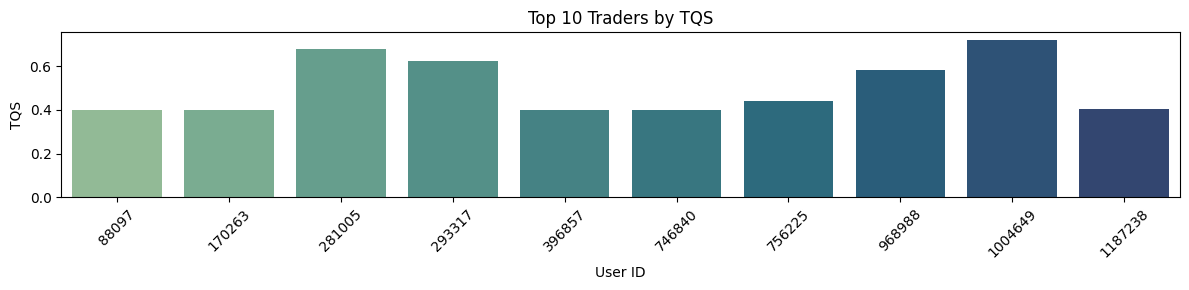

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 3))
sns.barplot(data=top_traders, x='user_id', y='TQS', palette='crest')

plt.title('Top 10 Traders by TQS')
plt.xlabel('User ID')
plt.ylabel('TQS')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Summary of Trader Quality Score (TQS) Results with Stakeholder Insights

The provided results showcase the top 10 and bottom 10 traders ranked by their Trader Quality Score (TQS), a composite metric derived from profitability, consistency, and risk management indicators. Below is a concise summary of the results, followed by actionable insights for stakeholders based on the TQS rankings, win rates, total profits, and trade counts.

---

### Key Observations from Results

#### Top 10 Traders
- **TQS Range**: 0.3984 to 0.7203 — indicating high-quality performance.
- **Win Rates**: 45.45% to 99.16%; most traders above 72%.  
  - _e.g., user 756225: 99.16% win rate_
- **Total Profit**: $501.65 to $10,736.17  
  - _e.g., user 293317: $10,736.17 with 10 trades_
- **Number of Trades**: 10 to 262  
  - _e.g., user 1004649: 11 trades, $8,051.77 profit_

**Notable Performers**:
- **User 1004649**: Highest TQS (0.7203), 72.73% win rate, $8,051.77 profit — high efficiency.
- **User 293317**: 90% win rate, $10,736.17 profit — strong performance with low activity.
- **User 756225**: 99.16% win rate, 238 trades, but lower profit ($918.23) — smaller consistent wins.

#### Bottom 10 Traders
- **TQS Range**: 0.1027 to 0.1833 — indicating poor performance.
- **Win Rates**: 0% to 56.34%; most below 25%.
- **Total Profit**: All negative, from -$509.20 to -$48,095.05.
- **Number of Trades**: 30 to 275  
  - _e.g., user 335404: 275 trades, overtrading with losses_

**Notable Underperformers**:
- **User 1049141**: Lowest TQS (0.1027), -$19,817.44, 2.14% win rate — high risk, low return.
- **User 159211**: -$48,095.05, 56.34% win rate — poor risk management.
- **User 96075**: 0% win rate, -$29,564.75 over 32 trades — zero profitability.

---

### Stakeholder Insights

#### For Trading Platform Operators:
- **Reward High Performers**: Incentivize users like 1004649 and 293317 with lower fees, premium access, or leaderboard recognition.
- **Mitigate Risk**: Flag bottom traders (e.g., 1049141, 159211) for interventions — trade caps, education, or suspension.
- **Optimize Resource Allocation**: Focus support on efficient traders with high TQS and moderate trade counts.

#### For Traders:
- **Top Traders**: Use high TQS as leverage for reputation, funding, or negotiating platform perks.
  - _e.g., user 293317: 90% win rate, $10K profit_
- **Bottom Traders**: Immediate strategy review needed.  
  - _e.g., user 1049141 should reduce frequency and improve reward-risk balance_
- **Learning Opportunity**: Study top trader strategies — selective trades, higher win consistency.

#### For Investors / Capital Allocators:
- **Capital Allocation**: Favor traders like 1004649 and 293317 for their efficiency and profitability.
- **Risk Assessment**: Avoid traders like 159211 with high losses and poor TQS.
- **Diversification**: Allocate across high-TQS traders with different styles and trade counts.

#### For Regulators / Auditors:
- **Risk Oversight**: Monitor traders with excessive losses (e.g., 159211) for reckless behavior.
- **Fair Evaluation**: Leverage TQS as a transparent and normalized performance benchmark.

---

### Strategic Recommendations

- **Incentivize Consistency**: Promote traders with strong win rates and low loss streaks (e.g., user 756225).
- **Targeted Interventions**: Offer feedback based on TQS components — e.g., user 1049141 needs risk-reward tuning.
- **Visualize Performance Gaps**: Use bar charts to show TQS ranges and illustrate gaps between top and bottom traders.

### Conclusion:

The TQS results reveal a stark contrast between top and bottom traders, with top performers demonstrating high win rates, significant profits, and efficient trading, while bottom traders exhibit consistent losses and poor risk management. Stakeholders can leverage these insights to reward high performers, guide underperformers, allocate capital effectively, and ensure regulatory compliance. The proposed chart and recommendations enhance decision-making by visualizing performance gaps and prioritizing actionable interventions.

